# CMC-13 Prática Laboratorial 03

- Ayrton da Silva Iseri

- Samuel Cruz Fernandes

Importando bibliotecas relevantes para o trabalho

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [43]:
DATASET_PREFIX = './data/'
votes_data = DATASET_PREFIX + 'republican_democrat.csv'

rank_data = DATASET_PREFIX + 'republican_democrat_test.csv'

Análise breve e superficial dos dados

In [44]:
poll_data = pd.read_csv(votes_data)
poll_data.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Target
0,n,y,n,y,y,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,y,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,n,n,n,y,?,y,y,y,y,democrat


Percebemos pela estrutura do dataset que cada coluna representa uma votação diferente que ocorreu sobre um grande projeto. 

Podendo haver votos favoráveis, desfavoráveis ou `?`, vamos fazer uma breve análise deste dataset e identificar como esta sua distribuição.

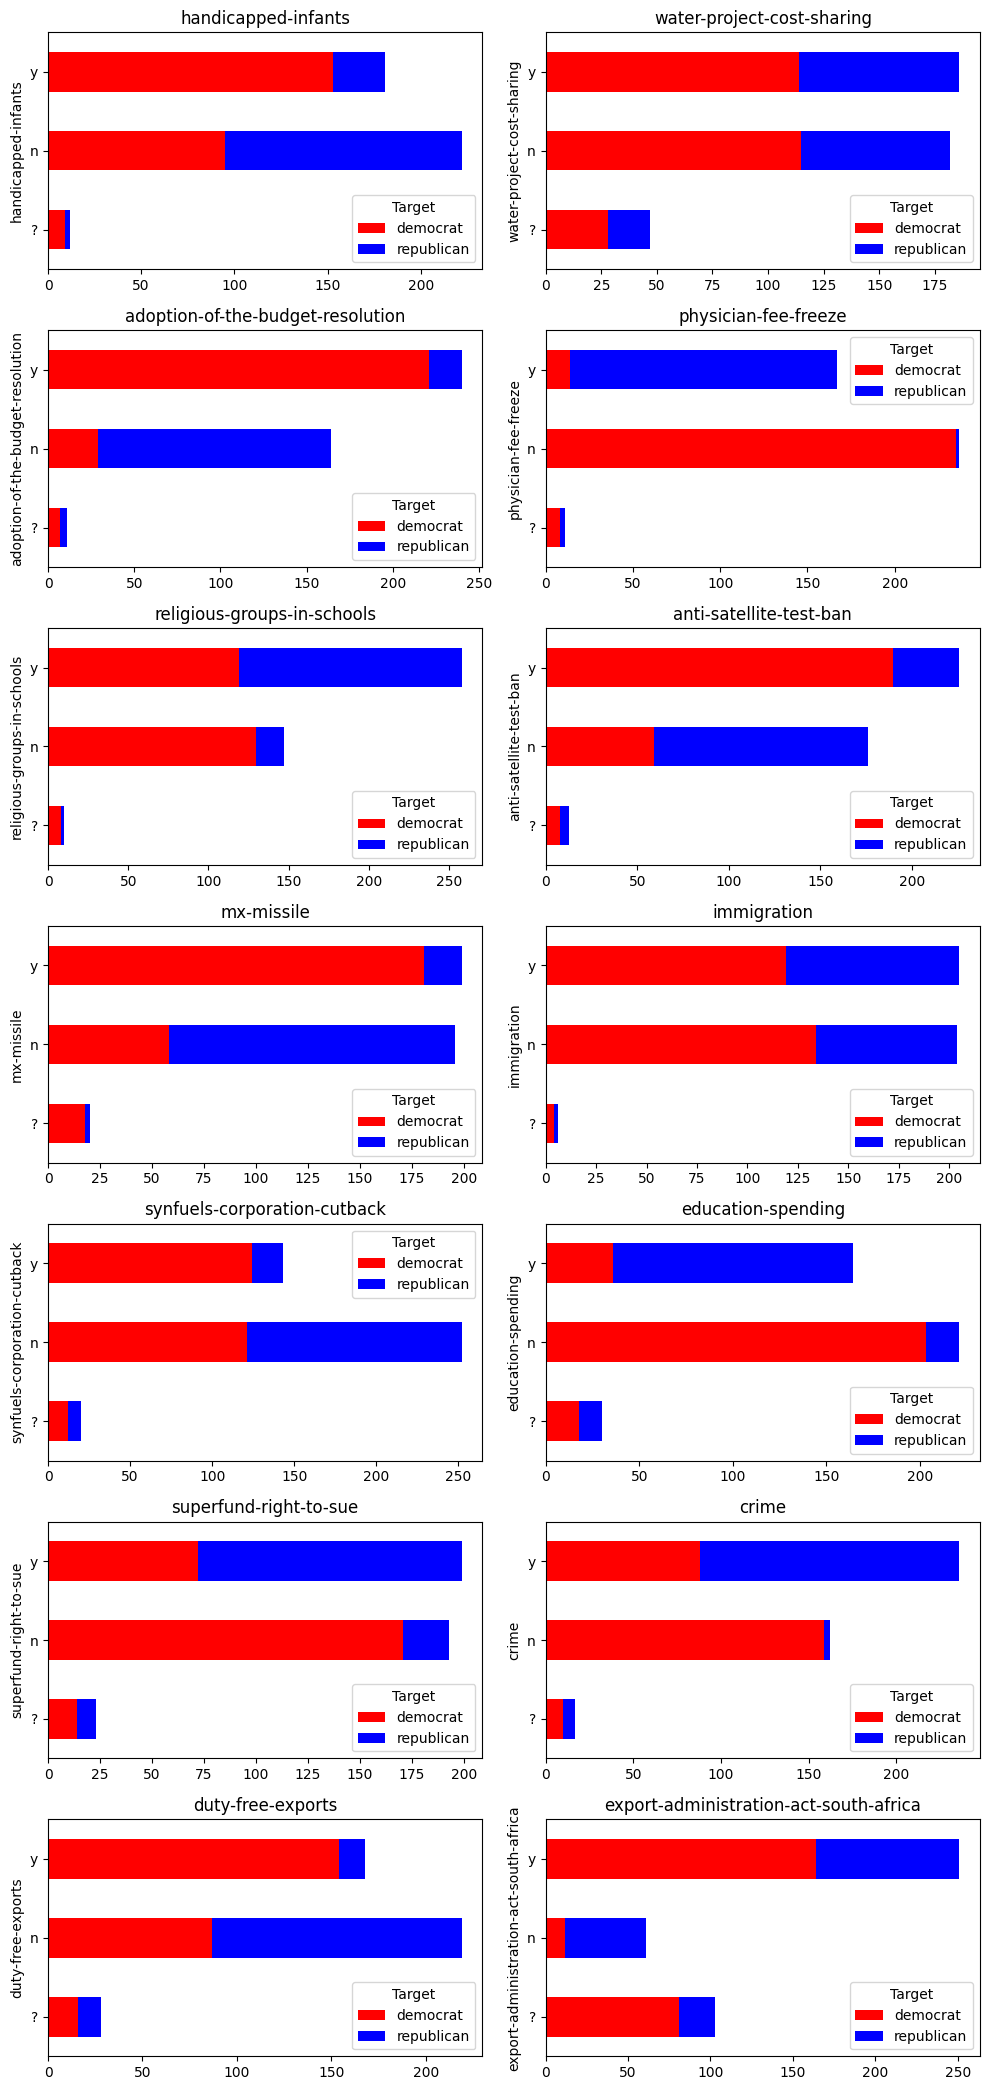

In [45]:
def plot_histograms(df: pd.DataFrame) -> None:
    num_columns = df.shape[1] - 1  # Exclude the color column
    num_rows = int(np.ceil(num_columns / 2.0))

    fig, axs = plt.subplots(num_rows, 2, figsize=(10, num_rows*3))
    axs = axs.flatten()  # Flatten to 1-D

    color_mapping = {'republican': 'blue', 'democrat': 'red'}  # Adjust this mapping to match your data

    for i in range(num_columns):
        column = df.columns[i]
        if column != 'Target':
            counts = df.groupby([column, 'Target']).size().unstack(fill_value=0)
            colors = [color_mapping[val] for val in counts.columns]
            counts.plot(kind='barh', stacked=True, color=colors, ax=axs[i])
            axs[i].set_title(column)

    # If number of columns is odd, remove the last subplot
    if num_columns % 2:
        fig.delaxes(axs[-1])

    plt.tight_layout()
    plt.show()

# Call the function
plot_histograms(df=poll_data)

Pode-se perceber, desta forma, que o posicionamento partidário aparenta ter fator relevante para a determinação do voto a ser expresso por um determinado indivíduo durante a votação.

Desta forma, vamos aplicar as redes de bayes para averiguar o poder preditivo/classificativo sobre este dataset

## Tratamento de abstenções

Para filtrar as abtenções, procurar-se-á distribuir os votos faltantes para o mesmo lado que o partido do político tenha se posicionado 

In [46]:
republican_vote_mapping = {}
democrat_vote_mapping = {}

for poll in poll_data.drop('Target', axis=1):
    poll_results = poll_data.groupby('Target')[poll].value_counts()
    republican_majority = poll_results['republican'].index[0]
    democrat_majority = poll_results['democrat'].index[0]

    republican_vote_mapping[poll] = republican_majority
    democrat_vote_mapping[poll] = democrat_majority

Com os `mappings`, vamos filtrar os `?` que aparecem no dataset original

In [47]:
def get_filiation_vote(filiation: str, poll: str) -> str:
    if filiation == 'republican':
        return republican_vote_mapping[poll]
    return democrat_vote_mapping[poll]

for idx, row in poll_data.iterrows():
    for poll, vote in row[:-1].items():
        if vote == '?':
            poll_data[poll][idx] = get_filiation_vote(row[-1], poll)
            
poll_data.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Target
0,n,y,n,y,y,n,n,y,n,y,y,y,n,y,republican
1,n,y,n,y,y,n,n,n,n,y,y,y,n,y,republican
2,y,y,y,n,y,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,y,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,n,n,n,y,n,y,y,y,y,democrat


Façamos agora um one-hot-encoding deste modelo. Mapearemos y = 1 e n = 0.

Como estamos trabalhando com um dataset binário, podemos utilizar a simples, porém otimizada, função `replace` da lib pandas

In [48]:
one_hot_mapper = {'y': 1, 'n': 0}

poll_data_encoded = poll_data.replace(one_hot_mapper)
poll_data_encoded.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Target
0,0,1,0,1,1,0,0,1,0,1,1,1,0,1,republican
1,0,1,0,1,1,0,0,0,0,1,1,1,0,1,republican
2,1,1,1,0,1,0,0,0,1,0,1,1,0,0,democrat
3,0,1,1,0,1,0,0,0,1,0,1,0,0,1,democrat
4,1,1,1,0,1,0,0,0,1,0,1,1,1,1,democrat


## Construção do modelo

Como se trata de um modelo probabilistico que trabalha com classificações binárias, é válido adotar a vertical de classificador Bayesiano Ingênuo de Bernoulli, que pressupoe uma distribuição de bernoulli para o dataset

In [49]:
X, y = poll_data_encoded.drop('Target', axis=1), poll_data_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
327,0,1,0,1,1,0,0,0,0,1,1,1,0,1
148,0,1,0,1,1,0,0,1,1,1,1,1,0,1
55,0,1,0,1,1,0,0,1,1,1,1,1,0,0
82,0,0,0,1,1,0,0,1,0,1,1,1,0,1
280,0,0,1,0,0,1,1,1,0,0,0,1,0,1


In [50]:
clf = BernoulliNB(force_alpha=True)

clf.fit(X_train, y_train)

BernoulliNB(force_alpha=True)

visualização dos resultados do modelo

In [51]:
y_pred = clf.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

    democrat       0.98      0.94      0.96        53
  republican       0.91      0.97      0.94        30

    accuracy                           0.95        83
   macro avg       0.94      0.96      0.95        83
weighted avg       0.95      0.95      0.95        83



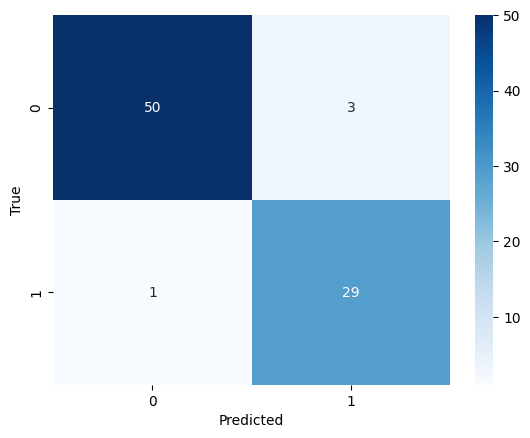

In [52]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Percebe-se que, de modo geral, este modelo é excelente em sua tarefa de fazer as classificações, com vários indicadores ultrapassando o piso de 95%.

Outro aspecto importante é o de que, pelo dataset de teste, percebe-se que o algoritmo associou `1` ao congressista republicano e `0` ao democrata

## Criação do Ranking

Devemos, primeiramente, tratar os dados da mesma maneira que fizemos com o primeiro dataset

In [53]:
id_data = pd.read_csv(rank_data, sep=';')

id_data.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,ID
0,y,y,y,n,n,y,y,n,n,n,n,n,n,y,101
1,y,y,n,y,y,n,n,y,n,n,y,y,n,y,102
2,n,y,y,n,y,y,?,y,n,n,n,n,n,y,103
3,y,y,y,y,y,y,n,y,n,n,y,y,n,y,104
4,y,y,y,n,n,y,y,n,n,n,n,n,n,y,105


Como não podemos determinar qual o posicionamento político associado a um determinado ID, simplesmente atribuiremos cada `?` à maioria dos votos

In [64]:
votes = poll_data.drop('Target',axis=1).columns.to_list()
total_votes = pd.concat([poll_data.drop('Target',axis=1), id_data.drop('ID',axis=1)])

max_mapper = {}

for col in total_votes:
    max_mapper[col] = total_votes[col].value_counts().index[0]

for col in id_data.drop('ID', axis=1):
    id_data[col] = id_data[col].replace({'?': max_mapper[col]})

id_data = id_data.replace(one_hot_mapper)

id_data.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,ID
0,1,1,1,0,0,1,1,0,0,0,0,0,0,1,101
1,1,1,0,1,1,0,0,1,0,0,1,1,0,1,102
2,0,1,1,0,1,1,1,1,0,0,0,0,0,1,103
3,1,1,1,1,1,1,0,1,0,0,1,1,0,1,104
4,1,1,1,0,0,1,1,0,0,0,0,0,0,1,105


Com isso, ja temos insumos suficientes para utilizar o modelo passado a atribuir uma probabilidade a cada congressista de pertencer ao partido republicano

In [83]:
rank = id_data[['ID']]
rank['Prob(republican)'] = [prob[1] for prob in clf.predict_proba(id_data.drop('ID',axis=1))]

rank = rank.sort_values(by='Prob(republican)', ascending=False)

rank

/tmp/ipykernel_101330/3341818977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank['Prob(republican)'] = [prob[1] for prob in clf.predict_proba(id_data.drop('ID',axis=1))]


,ID,Prob(republican)
7,108,9.999997e-01
11,112,9.999981e-01
5,106,9.999817e-01
17,118,9.999793e-01
9,110,9.999793e-01
1,102,9.995798e-01
19,120,9.995344e-01
15,116,9.977609e-01
13,114,8.440524e-01
3,104,8.440524e-01


# Considerações finais

Poderiamos ter amplificado ainda mais a eficiencia deste modelo, por exemplo, ao utilizar criterios de seleção de features mais eficientes como os valores de Shapley, utilizar hiperparametros mais eficientes e até avaliar curvas de calibraão do modelo de classificação de Bayes.

Por fim, o laboratório cumpre seu objetivo de introduzir o corpo discente aos conceitos de redes bayesianas e modelos probabilisticos.